# UC Severity Metagenomic-Metaproteomic Comparisons

By Robert Mills

Environment:Python3

Project Abstract:

Ulcerative colitis (UC) is a chronic autoimmune condition defined by intestinal inflammation and concurrent microbiome dysbiosis. Here, we advance the understanding of host-microbiome interactions governing UC by collecting six meta–omic datasets profiling host and microbial molecules in 40 patients displaying a wide range of clinically assessed disease activity (remission to severe). The six datasets provided unique evidence toward a central hypothesis of proteolysis co-occurring with increased disease activity. Metaproteomics identified Bacteroides proteases as a distinguishing feature of severity. Shotgun metagenomics guided taxonomic inferences and revealed that the Bacteroides association was driven primarily by changes in protein and not DNA abundances. Potential evidence of a host response to Bacteroides serine proteases was found in the increase of serum and fecal serine protease inhibitors. Metapeptidomics added evidence of protease activity as an increase of peptide fragments was present among the patients with high severity. In addition, we compare prediction of severity and clinical parameters between data types. In total, our meta-omic platform has provided compelling integrated evidence for host-microbiome interactions during UC and opens the door for protease inhibition as a therapeutic approach for severe UC patients.



<B>Dependencies</b>

In [2]:
import math
import re

import matplotlib.pyplot as plt
from biom import load_table
from skbio import TreeNode
import numpy as np
import pandas as pd
import scipy
import scipy.stats as stats
from patsy import dmatrix
import seaborn as sns
from scipy.stats import linregress

In [3]:
# Makes figures with white background
sns.set_style("whitegrid")
%matplotlib inline

<B>User Defined Functions</B>

In [4]:
ttests=[]
def ttest(df, df_sub1, df_sub2):
    """
    This function takes two subsetted dataframes where
    protein ID's are along the index and the samples
    you are testing are in the columns, and performs a
    ttest to determine whether each protein in the 
    subsets are at different levels. This function
    returns the original dataframe with a new column 
    for the p-value associated with the t-test. 
    equal_var can be set to True or false depending 
    on whether youneed to perform welches correction 
    on the data.
    
    parameters
    ----------
    df: pd.DataFrame
    df_sub1: pd.DataFrame
    df_sub2: pd.DataFrame
    
    returns
    -------
    dataframe with p-values
    
    """
    from scipy.stats import ttest_ind
    df_sub1 = df_sub1.transpose() # Transposition is  required
    df_sub2 = df_sub2.transpose()
    ttests = ttest_ind(df_sub1,df_sub2,equal_var=False,
                       nan_policy='omit')
    ttests = ttests.pvalue.transpose() # Transpose the pvalues back to the original orientation.
    df['ttest_pvalue']=ttests
    return df

In [5]:
def fold(df, sub1, sub2, sub1name, sub2name):
    """
    Creates a new column in your dataframe (df) for fold change between
    two sample types (in separate dataframes sub1 and sub2).
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1 : pd.DataFrame
    sub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Newly formed column in your dataframe.
    """
    df['%s Mean' % (sub1name)]=sub1.mean(axis=1,skipna=True)
    df['%s Mean' % (sub2name)]=sub2.mean(axis=1,skipna=True)
    df['Fold Change(%s/%s)' % (sub1name, sub2name)]=df['%s Mean' % (sub1name)]/df['%s Mean' % (sub2name)]
    return df['Fold Change(%s/%s)' % (sub1name, sub2name)]

In [6]:
def piscore(df,sub1name,sub2name):
    """
    pi score is a function which combines outputs from ttest and fold change functions
    and multiplies them to help pick biologically relevant hits within your systems.
    
    Parameters
    ----------
    df : pd.DataFrame
    sub1name : string
    sub2name: string
    
    Returns
    -------
    Newly formed column in your dataframe
    
    
    """
    df['Log2(Fold Change)'] = np.log2(df['Fold Change(%s/%s)'% (sub1name,sub2name)])
    df['-Log(P-value)'] = -np.log10(df['ttest_pvalue'])
    df['%s/%s pi score' % (sub1name,sub2name)] = df['-Log(P-value)']*df['Log2(Fold Change)']
    return df['%s/%s pi score' % (sub1name,sub2name)]

In [7]:
def TwoCategoryMaster(dfmain,dfsub1,dfsub2,sub1name,sub2name):
    """
    This function combines previously created user-defined functions to streamline the data
    analysis.
    
    Parameters
    ----------
    dfmain : pd.DataFrame
    dfsub1 : pd.DataFrame
    dfsub2 : pd.DataFrame
    sub1name : string
    sub2name : string
    
    Returns
    -------
    Updated dataframe
    """
    ttest(dfmain,dfsub1,dfsub2)
    fold(dfmain,dfsub1,dfsub2,sub1name,sub2name)
    piscore(dfmain,sub1name,sub2name)
    return dfmain

In [8]:
def TaxaRatioCompare(df_sig,df2_sig,Taxa,variable):
    """
    This function combines several lines of code to speed up comparative analyses between two data sets.
    Input the data frames you want to compare and the name of the taxonomic level under Taxa.
    
    Parameters
    ----------
    df_sig : pd.DataFrame
    df2_sig : pd.DataFrame
    Taxa, String
    variable : Name of variable you're comparing ratios of

    Returns
    -------
    Dataframe with comparative ratios
    Dataframe with counts
    """
    
    #Subset out the significant positive and negative correlations
    Cal_neg = df_sig[df_sig['rvalue'] < 0]
    Cal_pos = df_sig[df_sig['rvalue'] > 0]

    #Subset out the significant positive and negative correlations MG
    Cal_neg2 = df2_sig[df2_sig['rvalue'] < 0]
    Cal_pos2 = df2_sig[df2_sig['rvalue'] > 0]
    
    
    #pDB Use this code if you want to simply look at quantity of significant proteins
    Cal_neg['%s_Pos' % variable] = 0
    Cal_pos['%s_Pos' % variable] = 1
    Cal_neg['%s_Neg' % variable] = 1
    Cal_pos['%s_Neg' % variable] = 0

    #MG Use this code if you want to simply look at quantity of significant proteins
    Cal_neg2['%s_Pos2' % variable] = 0
    Cal_pos2['%s_Pos2' % variable] = 1
    Cal_neg2['%s_Neg2' % variable] = 1
    Cal_pos2['%s_Neg2' % variable] = 0
    
    df_sig = pd.concat([Cal_neg, Cal_pos])

    df_sig2 = pd.concat([Cal_neg2, Cal_pos2])
    
    #Sum by category

    #Use this for summing by taxonomy
    dfcategories = df_sig[['%s_Neg' % variable,'%s_Pos' % variable]].groupby(df_sig['%s' % Taxa]).agg(['sum'])
    dfcategories.columns = dfcategories.columns.droplevel(1)

    #Use this for summing by taxonomy
    dfcategories2 = df_sig2[['%s_Neg2' % variable,'%s_Pos2' % variable]].groupby(df_sig2['%s' % Taxa]).agg(['sum'])
    dfcategories2.columns = dfcategories2.columns.droplevel(1)
    
    #Save the postive and negative correlations per genera or eggNOG category
    counts = dfcategories.merge(dfcategories2, left_index = True, right_index = True, how = 'left')

    #Add a Pseudocount of 1 so that the categories without anything are still shown
    dfcategories = counts.replace(0,1)
    
    
    #Find the ratios necessary for calculating the ratio of ratios
    dfcategories['%s_Percent_Neg' % variable] = \
    dfcategories['%s_Neg' % variable]/dfcategories['%s_Neg' % variable].sum()
    dfcategories['%s_Percent_Pos' % variable] = \
    dfcategories['%s_Pos' % variable]/dfcategories['%s_Pos' % variable].sum()

    #Find the ratios necessary for calculating the ratio of ratios
    dfcategories['%s_Percent_Neg2' % variable] = \
    dfcategories['%s_Neg2' % variable]/dfcategories['%s_Neg2' % variable].sum()
    dfcategories['%s_Percent_Pos2' % variable] = \
    dfcategories['%s_Pos2' % variable]/dfcategories['%s_Pos2' % variable].sum()
    
    dfcategories['%s_Ratio of Percentages (Pos/Neg)' % variable] = dfcategories['%s_Percent_Pos' % variable]/dfcategories['%s_Percent_Neg' % variable]
    dfcategories['%s_Ratio of Percentages (Pos/Neg)2' % variable] = dfcategories['%s_Percent_Pos2' % variable]/dfcategories['%s_Percent_Neg2' % variable]
    
    
    dfcategories['%s_Log(Pos/Neg)' % variable] = np.log10(dfcategories['%s_Ratio of Percentages (Pos/Neg)' % variable])
    dfcategories['%s_Log(Pos/Neg)2' % variable] = np.log10(dfcategories['%s_Ratio of Percentages (Pos/Neg)2' % variable])
    
    global Ratios
    global Counts
    Ratios = dfcategories
    Counts = counts
    return 'Comparative ratios save under dataframe named Ratios, raw counts saved under datarame name Counts'

####  Loading data

In [35]:
#Switch between these to analyze either all the data or just the common to all proteins
df = pd.read_csv("./pDB_Proteomics/2Search/CSVs/NormalizedCommonReps.txt", 
                 sep = '\t', index_col= "datarest$ProteinID")
df2 = pd.read_csv("./pDB_Proteomics/2Search/CSVs/NormalizedDataAll.txt", sep = '\t',
                 index_col = "datarest$ProteinID")

In [14]:
#Load shotgun metagenome data
MG = pd.read_csv('./Genomics/Shotgun/Salmon_CPMs.csv', index_col="Name")

In [10]:
#Also read in the metadata
metadata = pd.read_table('./UC_MP_Emperor_Map.txt', index_col = "id")
protein_metadata = pd.read_csv('./Annotations/UniKB_Taxa_ghostKO_Merge.csv')
#human_metadata = pd.read_csv('./Annotations/Human_uniprot_Metaproteome.txt', sep = '\t')

/Users/rhmills/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,9,21,31,42,43,54,62,63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
#For annotating COG Categories
COG = pd.read_csv('../Georgia State Collaboration/COG.description.csv')
COG.columns = ['COG', 'COG Protein Name']
COG_cats = pd.read_csv('../Georgia State Collaboration/COG.funccat.csv')
COG_cats.columns = ['COG', 'eggNOG_Code']
Cat_key = pd.read_csv('../Georgia State Collaboration/eggNOG_FunCats.csv')

#### Start comparative analysis of metagenome and metaproteome

In [12]:
#Compile list of sample IDs
samples = list(df.columns)

In [15]:
#Switching the metagenome data into dataframe df to analyze metaproteome and metagenome side by side
df = MG

#Replace missing values with 0s
df.replace(np.nan, 0, inplace=True)

In [36]:
#Add the partial mayo scores to the dataframes
df2.loc['partial_mayo'] = metadata.partial_mayo.astype('float')
df.loc['partial_mayo'] = metadata.partial_mayo.astype('float')

In [37]:
#Create two forms of the dataframes before applying linear regressions
df2_m = df2.T
df_m = df.T
df2_n = df2
df_n = df

In [38]:
#Order the samples by severity
Cal_order = list(metadata['partial_mayo'].sort_values().index)
#Cal_order = list(metadata['pielou_e'].sort_values().index)

#Create list of new column names you want to add to dataframe
linregstats =['slope','intercept','rvalue','pvalue','stderr']

#Add new columns to list of ordered samples
for i in linregstats:
    Cal_order.append(i)

['L14',
 'L17',
 'L6',
 'L4',
 'L10',
 'L3',
 'L13',
 'L19',
 'L20',
 'H17',
 'L8',
 'L12',
 'L7',
 'L11',
 'L26',
 'H13',
 'L1',
 'L15',
 'L9',
 'L16',
 'H4',
 'L22',
 'H15',
 'H3',
 'H8',
 'L18',
 'H1',
 'H6',
 'H16',
 'H7',
 'H5',
 'H14',
 'H12',
 'H2',
 'H19',
 'H18',
 'H11',
 'H20',
 'H9',
 'H10',
 'slope',
 'intercept',
 'rvalue',
 'pvalue',
 'stderr']

In [39]:
#Reindex to sort the data columns
df_n.reindex(columns = Cal_order)
df2_n.reindex(columns = Cal_order)

,L14,L17,L6,L4,L10,L3,L13,L19,L20,H17,...,H18,H11,H20,H9,H10,slope,intercept,rvalue,pvalue,stderr
datarest$ProteinID,,,,,,,,,,,,,,,,,,,,,
A0A024R571,13.162424,33.361952,17.027028,14.409685,7.149332,12.549197,15.619409,17.696601,15.732897,9.868662,...,72.422449,669.331934,41.300378,3809.094975,1826.080258,NaN,NaN,NaN,NaN,NaN
A0A024R6I7,23.855362,24.983757,23.919234,34.608663,15.590950,76.014254,27.469511,63.956920,34.720513,85.277749,...,133.583660,767.171442,133.868931,780.173480,1177.576453,NaN,NaN,NaN,NaN,NaN
A0A024RA52,30.563442,41.540822,NaN,58.579410,16.273842,61.317926,64.559368,26.140454,21.421420,NaN,...,48.517399,809.973507,137.110188,1601.956458,1557.658038,NaN,NaN,NaN,NaN,NaN
A0A075B6H7,30.742672,75.590582,112.844955,122.926797,16.165448,95.849930,41.503223,116.511611,48.685265,48.725070,...,63.019403,942.338267,157.960374,748.118066,627.903394,NaN,NaN,NaN,NaN,NaN
A0A075B6H9,NaN,NaN,NaN,234.841562,10.543998,45.702683,42.905921,96.043006,26.304391,NaN,...,156.728668,339.199928,186.073432,709.469435,NaN,NaN,NaN,NaN,NaN,NaN
A0A075B6I0,38.406978,52.211455,158.467557,192.075194,8.405219,87.964370,NaN,NaN,29.442311,107.521413,...,9.590530,1772.501460,156.668500,NaN,1166.903896,NaN,NaN,NaN,NaN,NaN
A0A075B6I9,8.940843,69.222741,177.578334,229.823989,8.095686,148.423001,108.947749,61.598822,36.240338,136.244781,...,31.131065,1177.889468,146.229629,791.278022,869.536657,NaN,NaN,NaN,NaN,NaN
A0A075B6J9,2.558791,72.105493,76.168176,120.795329,8.794565,108.962559,25.280904,69.005552,20.547119,68.494657,...,29.820934,726.380748,452.439747,989.276533,441.479824,NaN,NaN,NaN,NaN,NaN
A0A075B6K4,26.739960,86.159643,NaN,59.230094,10.884506,76.906752,41.571592,184.365626,76.660686,NaN,...,27.777358,3161.742638,61.031392,1543.095344,1444.128669,NaN,NaN,NaN,NaN,NaN


In [ ]:
#Apply linear regressions to the severity score for the metagenome

slope = []
intercept = []
rvalue = []
pvalue = []
stderr = []

for i in df_m:
    a = df_n.loc[i]
    b = df_n.loc['partial_mayo']
    linres = linregress(a[samples],b[samples])
    slope.append(linres.slope)
    intercept.append(linres.intercept)
    rvalue.append(linres.rvalue)
    pvalue.append(linres.pvalue)
    stderr.append(linres.stderr)
df_n['slope'] = slope
df_n['intercept'] = intercept
df_n['rvalue'] = rvalue
df_n['pvalue'] = pvalue
df_n['stderr'] = stderr

In [40]:
#Apply linear regressions to the severity

slope = []
intercept = []
rvalue = []
pvalue = []
stderr = []

for i in df2_m:
    a = df2_n.loc[i]
    b = df2_n.loc['partial_mayo']
    #Use this if you want to use the minimum values for each of the samples instead of NAs
    df2_n.loc[i].replace(np.nan, a.min(), inplace = True)
    #Perform regression only on the samples
    linres = linregress(a[samples],b[samples])
    slope.append(linres.slope)
    intercept.append(linres.intercept)
    rvalue.append(linres.rvalue)
    pvalue.append(linres.pvalue)
    stderr.append(linres.stderr)
df2_n['slope'] = slope
df2_n['intercept'] = intercept
df2_n['rvalue'] = rvalue
df2_n['pvalue'] = pvalue
df2_n['stderr'] = stderr

/Users/rhmills/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/scipy/stats/_stats_mstats_common.py:117: RuntimeWarning: invalid value encountered in absolute
  prob = 2 * distributions.t.sf(np.abs(t), df)


In [46]:
#Save the dataframes for loading again later...

#df2_n.to_csv('./pDB_Proteomics/pmayo_correlations_MP_corrwmin_new.csv')
#df_n.to_csv('./pDB_Proteomics/pmayo_correlations_MG_corrw0s_new.csv')

,Name,H1,H2,H3,H4,H5,H6,H7,H8,H9,...,L19,L20,L22,L26,sum,slope,intercept,rvalue,pvalue,stderr
0,k99_6_1,0.000000,0.000000,1.293310,0.00000,0.00000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,4.537868,-0.433305,3.349157,-0.077317,0.635356,0.906408
1,k99_8_1,0.000000,0.273802,1.818020,0.00000,0.00000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,2.332214,0.455294,3.273454,0.048206,0.767701,1.530371
2,k99_9_1,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.188473,0.282654,0.000000,10.295307,0.062856,3.283822,0.032591,0.841760,0.312694
3,k99_11_1,0.000000,0.000000,0.000000,0.00000,6.52664,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,14.560530,0.700350,3.045063,0.383482,0.014580,0.273614
4,k99_12_1,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,8.064750,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,8.064750,0.216199,3.256410,0.100683,0.536470,0.346570
5,k99_13_1,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,4.109755,1.060287,3.191062,0.148035,0.361976,1.149092
6,k99_17_1,0.762226,4.620210,1.941210,0.00000,0.00000,1.426740,0.565962,0.715376,0.0000,...,0.000000,1.130580,0.767511,0.305027,26.428687,-0.026833,3.317729,-0.010408,0.949175,0.418185
7,k99_18_1,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN,0.000000,1.000000,inf
8,k99_19_1,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,0.0000,...,0.000000,0.000000,0.000000,0.000000,0.662892,-5.105832,3.384615,-0.195444,0.226817,4.156182
9,k99_22_1,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.884407,0.000000,0.0000,...,1.017160,0.813892,0.000000,0.000000,4.956229,-1.614780,3.500081,-0.247807,0.123140,1.024111


In [45]:
#Loading in pre-computed MG values -- It takes awhile to run the previous code
df_n = pd.read_csv('./pDB_Proteomics/pmayo_correlations_MG_corrw0s_new.csv')

In [33]:
#See how many proteins and genes have "medium" effect size at 0.3 r
len(df_n[abs(df_n['rvalue']) > 0.3])

62982

In [30]:
#See how many proteins and genes have "medium" effect size at 0.3 r
len(df2_n[abs(df2_n['rvalue']) > 0.3])

3636

In [47]:
#Subset out significant genes and proteins

df_sig = df_n[abs(df_n['rvalue']) > 0.3]
df2_sig = df2_n[abs(df2_n['rvalue']) > 0.3]

#Change index
df_sig.index = df_sig['Name']

#Index is correct if running from above
#df2_sig.index = df2_sig['datarest$ProteinID']

In [48]:
#Merge significant genes or proteins with their annotations.

df_sig = df_sig.merge(protein_metadata,left_index = True, right_on = "queryID")
df2_sig = df2_sig.merge(protein_metadata,left_index = True, right_on = "queryID")

In [50]:
#Perform taxa comparison
TaxaRatioCompare(df2_sig,df_sig,'Genus','partial_mayo')

/Users/rhmills/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/rhmills/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

'Comparative ratios save under dataframe named Ratios, raw counts saved under datarame name Counts'

In [ ]:
#Save the ratios and counts

#Ratios.to_csv('./pDB_Proteomics/pMayo_r0.3_ratios.csv')
#Counts.to_csv('./pDB_Proteomics/pMayo_r0.3_counts.csv')

#### Barplot composition of correlated proteins

In [56]:
Counts.rename(columns = {'partial_mayo_Neg' : 'Negative Correlations','partial_mayo_Pos' : 'Positive Correlations'}, inplace=True)

In [58]:
#Optionally drop out the human proteins from the analysis
Counts.drop("Homo",axis=0, inplace=True)

In [59]:
#Find the sum
High_severity_sum = Counts['Positive Correlations'].sum()
Low_severity_sum = Counts['Negative Correlations'].sum()

#Calculate fractional abundances
Counts['High Severity'] = Counts['Positive Correlations']/High_severity_sum
Counts['Low Severity'] = Counts['Negative Correlations']/Low_severity_sum

#Remove low abundance features and recalculate fractional abundance
cols = ['High Severity', 'Low Severity']
Counts['sum'] = Counts[cols].sum(axis = 1)
Counts = Counts[Counts['sum'] > 0.03]
for i in cols:
    Counts[i] = Counts[i]/Counts[i].sum()

/Users/rhmills/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [60]:
#Transpose the plot to make it fit the code structure I'm following for the stacked bar chart

#Remove index name
del Counts.index.name
#Sort samples by time
#order=['Negative', 'Positive']
order=['Low Severity', 'High Severity']
#Transpose
Counts = Counts.transpose()
#Get the dates in the correct order
Counts = Counts.reindex(order)
#Get Phyla into an order which depends on the abundance of each phyla for easier interpretation
Counts = Counts[Counts.sum().sort_values(ascending = False).index]

In [64]:
#Adjust color of plot if desired
vals = np.linspace(0,1,11)
np.random.shuffle(vals)
my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))

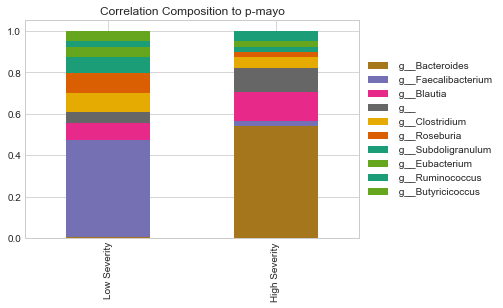

In [65]:
#Simple Plot
#my_cmap = plt.cm.get_cmap('Vega20')
plot1 = Counts.plot(kind='bar',stacked=True, colormap=my_cmap, title='Correlation Composition to p-mayo')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.savefig('./pdfs/UC_MP_LRr0.3_Genus_HostFilt_0.03filt.pdf',bbox_inches="tight")

#### Find the number of proteins with a particular category in each genera

In [51]:
#Load the metaproteome correlations again
df_n = pd.read_csv('./pDB_Proteomics/pmayo_correlations_MP_corrwmin_new.csv')
df_n = df_n.merge(protein_metadata, left_on = 'datarest$ProteinID', right_on = 'queryID')

,datarest$ProteinID,H16,H3,L4,L11,H8,L3,H11,H20,L10,...,queryEnd,queryID,queryStart,subjectEnd,subjectID,subjectStart,yourlist:M201806138A530B6CA0138AFAA6D2B97CE8C2A9241E0E8BI,yourlist:M201806139011D4373CD8E192AC56F039114E72590DB1D75,yourlist:M20180613E29AEE828664DEEC55715D2BCC1634E10E6B3AR,yourlist:M20180613E29AEE828664DEEC55715D2BCC1634E10E6B96H
0,A0A024R571,51.703963,153.678631,14.409685,89.481476,63.879952,12.549197,669.331934,41.300378,7.149332,...,NaN,A0A024R571,NaN,NaN,A0A024R571,NaN,NaN,NaN,NaN,NaN
1,A0A024R6I7,201.451149,128.326688,34.608663,76.858621,96.339274,76.014254,767.171442,133.868931,15.590950,...,NaN,A0A024R6I7,NaN,NaN,A0A024R6I7,NaN,NaN,NaN,NaN,NaN
2,A0A024RA52,132.421604,157.927237,58.579410,53.203684,29.018210,61.317926,809.973507,137.110188,16.273842,...,NaN,A0A024RA52,NaN,NaN,A0A024RA52,NaN,NaN,NaN,NaN,NaN
3,A0A075B6H7,193.248612,232.181595,122.926797,208.338611,57.318410,95.849930,942.338267,157.960374,16.165448,...,NaN,A0A075B6H7,NaN,NaN,A0A075B6H7,NaN,NaN,NaN,NaN,NaN
4,A0A075B6H9,328.111462,90.927152,234.841562,110.802246,34.473686,45.702683,339.199928,186.073432,10.543998,...,NaN,A0A075B6H9,NaN,NaN,A0A075B6H9,NaN,NaN,NaN,NaN,NaN
5,A0A075B6I0,253.369689,180.746259,192.075194,62.311155,41.787676,87.964370,1772.501460,156.668500,8.405219,...,NaN,A0A075B6I0,NaN,NaN,A0A075B6I0,NaN,NaN,NaN,NaN,NaN
6,A0A075B6I9,189.823533,120.915790,229.823989,43.926574,33.771287,148.423001,1177.889468,146.229629,8.095686,...,NaN,A0A075B6I9,NaN,NaN,A0A075B6I9,NaN,NaN,NaN,NaN,NaN
7,A0A075B6J9,18.895193,107.094718,120.795329,48.460563,26.949215,108.962559,726.380748,452.439747,8.794565,...,NaN,A0A075B6J9,NaN,NaN,A0A075B6J9,NaN,NaN,NaN,NaN,NaN
8,A0A075B6K4,236.544298,33.602488,59.230094,39.651949,6.797338,76.906752,3161.742638,61.031392,10.884506,...,NaN,A0A075B6K4,NaN,NaN,A0A075B6K4,NaN,NaN,NaN,NaN,NaN
9,A0A075B6K5,506.392168,156.895534,138.756778,79.864971,40.716891,115.613003,2010.053570,99.421913,15.900245,...,NaN,A0A075B6K5,NaN,NaN,A0A075B6K5,NaN,NaN,NaN,NaN,NaN


In [52]:
#Count the number of proteins in a given category

#Switch sign for positive or negative correlations
df_sig = df_n[df_n['rvalue'] < -0.3]


#Switch the category, in paper we use Membrane Transporters and Enzyme Families
Enzymes = df_sig[df_sig['KEGG Functional Categories'] == 'Membrane Transport']
#Enzymes.to_csv('./MP_Sig_Membrane.csv')

#Enzymes = Enzymes[Enzymes['rvalue'] < 0]

#Generate a dataframe from the counts of each category
from collections import Counter
counts = Counter(Enzymes['Genus'])
countsdf = pd.DataFrame.from_dict(counts, orient = 'index')

,0
g__Coprococcus,1
g__Eubacterium,3
g__Faecalibacterium,26
g__Ruminococcus,5
g__Clostridium,4
g__Roseburia,5
g__,1
g__Blautia,14
g__Butyricicoccus,2


In [ ]:
#Save the dataframe for figure generation
countsdf.to_csv('./pDB_Proteomics/r0.3_Membrane_genus_counts.csv')

#### Taxonomic barplots

In [158]:
#Load in whichever dataset you would like to analyze

#16S
#Supplemental figure uses both phylum and genus compositions
#df = pd.read_csv('./Genomics/16S/16S_genus_composition_idswap2_fullname.csv', index_col = "index")
#df = pd.read_csv('./Genomics/16S/16S_phyla_composition_idswap2.csv', index_col = "index")


#Unipep Normalized Peptides
#df = pd.read_csv('./smallDB_correct/unipeptCSVs/UnipepNormalizedDataAll.txt', sep = '\t', index_col = 'datarest$ProteinID')
#pep_ann = pd.read_csv('./smallDB_correct/unipept_result.csv', index_col = 'peptide')
#df = df.merge(pep_ann,left_index = True, right_index = True)
#Supplemental figure uses genus, main figure uses phylum, switch here:
#df = df[samples].groupby(df['genus']).agg(['sum'])
#df.columns = df.columns.droplevel(1)

#Shotgun Metagenomics
df = pd.read_csv('./Genomics/Shotgun/Salmon_CPMs.csv', index_col="Name")
MG_ann = pd.read_csv('./Annotations/UniKB_Taxa_ghostKO_Merge.csv')
df = df.merge(MG_ann,left_index = True, right_on = "queryID")
df = df[samples].groupby(df['Genus']).agg(['sum'])
df.columns = df.columns.droplevel(1)

/Users/rhmills/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (5,9,21,31,42,43,54,62,63,64,65) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [159]:
dfcategories = df

In [160]:
for i in samples:
    dfcategories[i] = dfcategories[i]/dfcategories[i].sum()

In [161]:
dfcategories['sum'] = dfcategories[samples].sum(axis = 1)
#Can adjust the number of categories present 0.03 was the standard
dfcategories = dfcategories[dfcategories['sum'] > 0.03]
for i in samples:
    dfcategories[i] = dfcategories[i]/dfcategories[i].sum()

/Users/rhmills/miniconda3/envs/qiime2-2018.4/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [162]:
dfcategories = dfcategories[samples]

In [163]:
Cal_order = list(metadata['partial_mayo'].sort_values().index)

In [164]:
#Transpose the plot to make it fit the code structure I'm following for the stacked bar chart

#Remove index name
del dfcategories.index.name
#Transpose
dfcategories = dfcategories.transpose()
#Get the samples in the correct order
dfcategories = dfcategories.reindex(Cal_order)
#Get Phyla into an order which depends on the abundance of each phyla for easier interpretation
dfcategories = dfcategories[dfcategories.sum().sort_values(ascending = False).index]

In [168]:
numcolors = len(dfcategories.columns)

In [169]:
vals = np.linspace(0,1,numcolors)
np.random.shuffle(vals)
my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals))

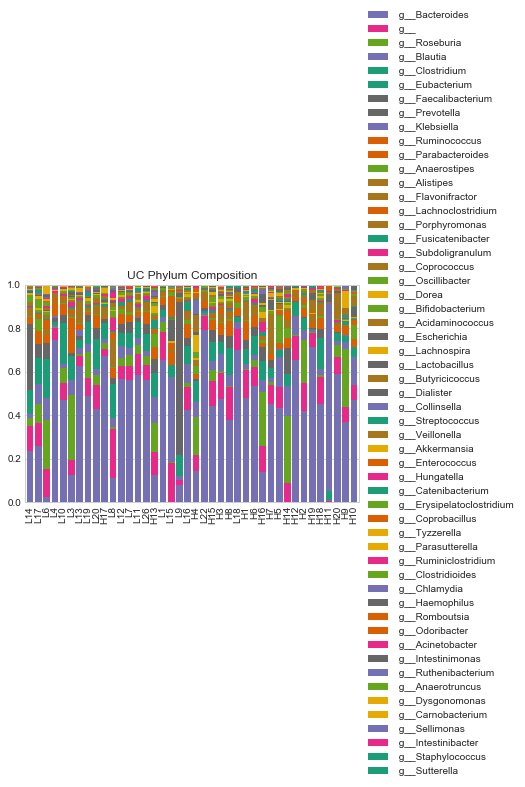

In [170]:
#Simple Plot
#my_cmap = plt.cm.colors.ListedColormap(plt.cm.Dark2(vals2))
#my_cmap = plt.cm.get_cmap('my_cmap')
plot1 = dfcategories.plot(kind='bar', width = 0.8, stacked=True, colormap=my_cmap, title='UC Phylum Composition')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plot1
#plt.savefig('UC_MPunipept_Genus_pmayoordered.pdf',bbox_inches="tight")